<a href="https://colab.research.google.com/github/Isra1997/ECG-Signal-filter/blob/master/ECGFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

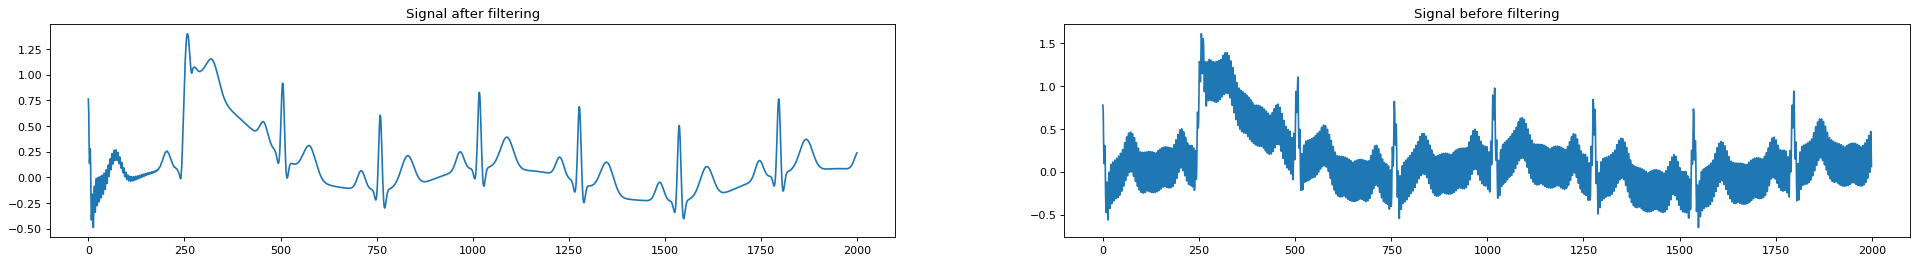

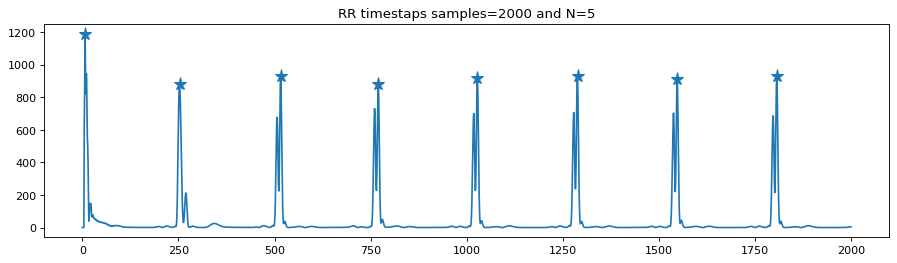

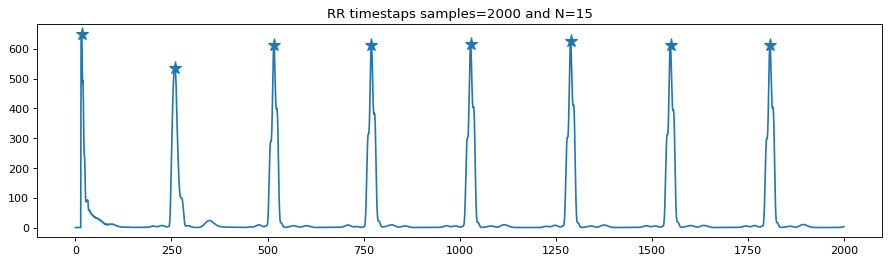

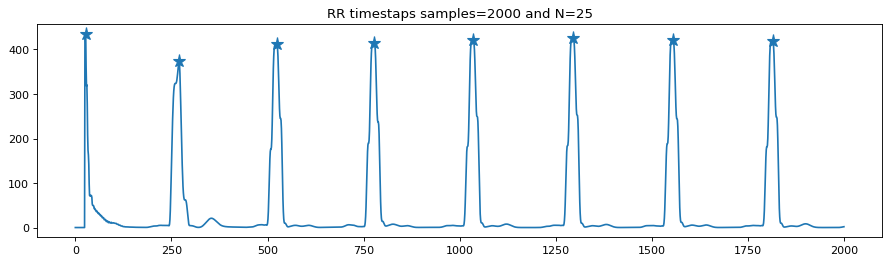

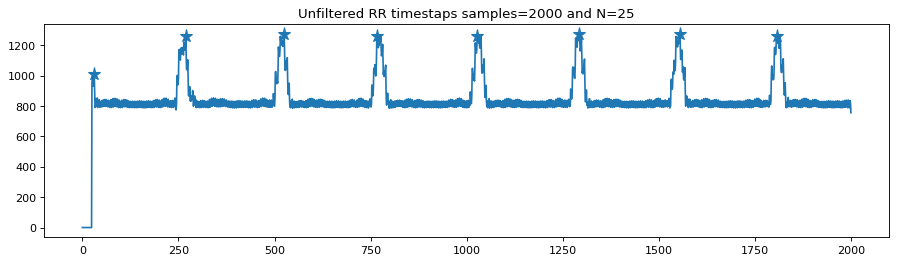

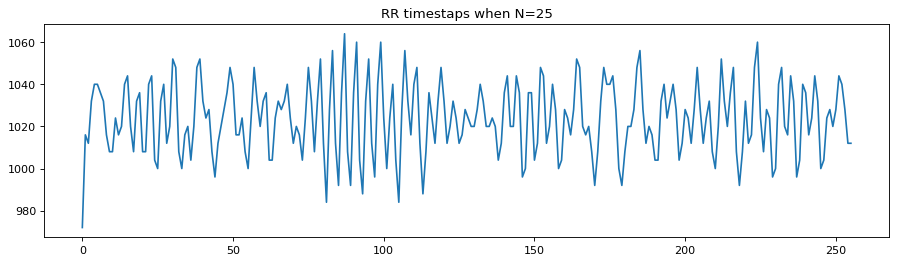

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import butter, iirnotch, lfilter,find_peaks

# Sampling rate 
fs=256

def notchfilter(cutoff,q,signal):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    powerline=lfilter(b,a,signal)
    return powerline

def bandpass(lowcut, highcut,signal,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filband=lfilter(b,a,signal)
    return filband

def diffrentiate(signal):
  diffSignal=np.zeros(signal.shape)
  T=(1/256)
  for i in range(2,len(signal)-2):
    diffSignal[i]=(1/(8*T))*(-signal[i-2]-2*signal[i-1]+2*signal[i+1]+signal[i+2])
  return diffSignal

def movingAverage(signal,n):
  smoothSignal=np.zeros(signal.shape)
  for i in range(n,len(signal)):
     smoothSignal[i]=(1/n)*np.sum(signal[i-n:i])
  return smoothSignal

def squaring(signal):
  squared_signal=np.zeros(signal.shape)
  for i in range(0,len(signal)):
    squared_signal[i]=signal[i]**2
  return squared_signal

def thresholdCalculation(signal):
  peakarray=np.asarray(find_peaks(signal)[0])
  valarray=np.zeros(peakarray.shape)
  for i in range(0,len(peakarray)):
    valarray[i]=signal[peakarray[i]]
  return np.amax(valarray)*0.69

# 1. Use a moving window on the the signal with a window of the size N.
# 2. We get the maximum of the the given window
# 3. We check that the maximum is greater than the given threshold
# 4. We get the exact index of the suspected R peak (wavepeak)
# 5. We check that the if the Rpeak array is empty
# 6. Than we append the peak
# 7. We check that if the current suspected maxmum index minus the last added index is less that the window size
# 8. And the signal at the current index is greater than the last added index.
# 9. If so than we change the the lase added index with the current index.
# 10. If the above condition is not satisfied.
# 11. We further check that the current index minus the last added index is not less than the window size.
# 12. Than we append the index to the Rpeak array. 

def thresholding(signal,threshold,n):
  RPeak=[]
  for i in range(n,len(signal),n):
    R=np.amax(signal[i-n:i])
    if(R>=threshold):
      m,=np.where(signal[i-n:i] == R)
      wavepeak=i-n+m[0]
      if(len(RPeak)>0):
        if(wavepeak-RPeak[len(RPeak)-1]<=(n) and signal[RPeak[len(RPeak)-1]]<signal[wavepeak]):
          RPeak[len(RPeak)-1]=wavepeak
        else:
          if((wavepeak-RPeak[len(RPeak)-1]<=(n))== False):
            RPeak.append(wavepeak)
      else:
         RPeak.append(wavepeak)

  return RPeak

def RRInterval(RRtime):
  inverval_array=[]
  for i in range(1,len(RRtime)):
    inverval_array.append(RRtime[i]-RRtime[i-1])
  return inverval_array

def unfiltered(signal,window,end):
  # differntiating the signal to make it positive
  diffSignal=diffrentiate(signal[0:end])
  # squaring the signal to amplify it non-linearly
  squreSignal=squaring(diffSignal)
  # smooth the signal to get thr R-peak
  smoothSignal=movingAverage(squreSignal,window)
  # calculating the threshold
  th=thresholdCalculation(smoothSignal)
  # getting the R timestamps
  RRtimeStamps=thresholding(smoothSignal,th,window)
  # calculating the RR intervals
  RRinterval=RRInterval(RRtimeStamps)
  return RRtimeStamps,RRinterval,smoothSignal

def ECGFlt(signal,window,end):
  # remove the noise caused by the powerline 50Hz
  powerline=notchfilter(50,30,signal[0:end])
  # bandpass filter 0.1-45Hz to get only the QRS wave
  band_signal=bandpass(0.1,45,powerline)
  # differntiating the signal to makeit positive
  diffSignal=diffrentiate(band_signal)
  # squaring the signal to amplify it non-linearly
  squreSignal=squaring(diffSignal)
  # smooth the signal to get thr R-peak
  smoothSignal=movingAverage(squreSignal,window)
  # calculating the threshold
  th=thresholdCalculation(smoothSignal)
  # getting the R timestamps
  RRtimeStamps=thresholding(smoothSignal,th,window)
  # calculating the RR intervals
  RRinterval=RRInterval(RRtimeStamps)
  return RRtimeStamps,RRinterval,smoothSignal

def main():
  # load the signal as an np array
  signal = np.loadtxt("DataN.txt", skiprows=0)
  powerline=notchfilter(50,30,signal[0:2000])
  band=bandpass(0.1,45,powerline)

  # plot 1
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  ax1 = plt.subplot(321)
  plt.plot(powerline)
  ax1.set_title("Signal after filtering")

  # plot 2
  ax2=plt.subplot(322)
  plt.plot(signal[0:2000])
  ax2.set_title("Signal before filtering")
  plt.savefig('Before_After_Filter.jpg')
  plt.show()

  # plot 3
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  RRtimeStamps,RRinterval,smoothSignal=ECGFlt(signal,5,2000)
  ax3=plt.subplot(323)
  plt.plot(smoothSignal,markevery=RRtimeStamps,marker='*',markersize=12)
  ax3.set_title("RR timestaps samples=2000 and N=5")
  plt.savefig('DetectedR_5.jpg')
  plt.show()

  # plot 4
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  RRtimeStamps_15,RRinterval_15,smoothSignal_15=ECGFlt(signal,15,2000)
  ax3=plt.subplot(323)
  plt.plot(smoothSignal_15,markevery=RRtimeStamps_15,marker='*',markersize=12)
  ax3.set_title("RR timestaps samples=2000 and N=15")
  plt.savefig('DetectedR_15.jpg')
  plt.show()

  # plot 5
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  RRtimeStamps_25,RRinterval_25,smoothSignal_25=ECGFlt(signal,25,2000)
  ax3=plt.subplot(323)
  plt.plot(smoothSignal_25,markevery=RRtimeStamps_25,marker='*',markersize=12)
  ax3.set_title("RR timestaps samples=2000 and N=25")
  plt.savefig('DetectedR_25.jpg')
  plt.show()

  # What can you conclude about the optimal setting of N? Explain your answer.
  # When the window size (N) increases it reaches the width of the QRS signal which results in 
  # acurate result of the R Peak as the only peak in the window becames the R peak.
  # The optimal window size is N=25.

  # plot 6
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  RRtimeStamps_25,RRinterval_25,smoothSignal_25=unfiltered(signal,25,2000)
  ax4=plt.subplot(323)
  plt.plot(smoothSignal_25,markevery=RRtimeStamps_25,marker='*',markersize=12)
  ax4.set_title("Unfiltered RR timestaps samples=2000 and N=25")
  plt.savefig('Unfiltered_25.jpg')
  plt.show()

  # plot 7
  plt.figure(num=1, figsize=(30, 12), dpi=80, facecolor='w', edgecolor='k')
  RRtimeStamps_25,RRinterval_25,smoothSignal_25=ECGFlt(signal,25,len(signal))
  x=list(range(0,len(RRinterval_25)))
  # T=(1/256)*1000 ~= 4 msec
  msec_RRinterval_25=np.multiply(RRinterval_25,4)

  ax4=plt.subplot(323)
  plt.plot(x,msec_RRinterval_25)
  ax4.set_title("RR timestaps when N=25")
  plt.savefig('RR.jpg')
  plt.show()



if __name__=='__main__':
  main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')